Скачивание и обработка датасета

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv ('card_transdata.csv')
shuffledData = data.sample (frac = 1)
fraudData = shuffledData.loc [shuffledData ['fraud'] == 1].sample (n = 20000)
nonFraudData = shuffledData.loc [shuffledData ['fraud'] == 0].sample (n = 20000)
data = pd.concat ([fraudData, nonFraudData])
data = data [data.distance_from_home <= 500]
data = data [data.distance_from_last_transaction <= 100]
data = data [data.ratio_to_median_purchase_price <= 50]
labels = data ['fraud'].to_numpy ()
data = data.drop (['fraud'], axis = 1).to_numpy ()
pass

Разделение выборки на обучающую и тестовую, определение вспомогательной функции для вывода метрик

In [2]:
from sklearn.model_selection import train_test_split
trainData, testData, trainLabels, testLabels = train_test_split (data, labels, train_size = 0.8, random_state = 1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
def showMetrics (model, data, labels):
    prediction = model.predict (data)
    print ('Accuracy: ', accuracy_score (labels, prediction))
    print ('Precision: ', precision_score (labels, prediction))
    print ('Recall: ', recall_score (labels, prediction))
    ConfusionMatrixDisplay.from_predictions (labels, prediction)
    RocCurveDisplay.from_predictions (labels, prediction)

### Логистическая регрессия

Определение модели

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LogisticRegression (BaseEstimator, ClassifierMixin):
    def __init__ (self, lr = 0.01, batch_size = 100, epochs = 5):
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def sigmoid (self, x):
        return 1 / (1 + np.exp (- x))
    
    def fit (self, data, labels):
        self.w = np.random.normal (0, 1, (data.shape [1] + 1,))
        data = np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1)
        for j in range (self.epochs):
            for i in range (self.batch_size, len (data), self.batch_size):
                batchData = data [i - self.batch_size:i]
                batchLabels = labels [i - self.batch_size:i]
                prediction = self.sigmoid (np.dot (self.w, batchData.T))
                self.w -= self.lr * (self.w + np.dot (prediction - batchLabels, batchData))
        return self
    
    def predict (self, data):
        return (self.sigmoid (np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1).dot (self.w)) > 0.5).astype('float32')

Подбор гиперпараметров при помощи RandomizedSearch

In [4]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [5]:
rcv = RandomizedSearchCV (Pipeline ([('normalizer', Normalizer ()), ('log', LogisticRegression ())]),
                    {'log__lr': [0.01, 0.001, 0.0001], 'log__epochs': [1, 5, 10], 'log__batch_size': [100, 1000, 10000]})
rcv.fit (trainData, trainLabels)
print (rcv.best_params_, '\n', rcv.best_score_)

{'log__lr': 0.01, 'log__epochs': 10, 'log__batch_size': 100} 
 0.6959846424572068


Подбор гиперпараметров при помощи GridSearch

In [6]:
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer ()), ('log', LogisticRegression ())]),
                    {'log__lr': [0.01, 0.001, 0.0001], 'log__epochs': [1, 5, 10], 'log__batch_size': [100, 1000, 10000]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'log__batch_size': 1000, 'log__epochs': 10, 'log__lr': 0.001} 
 0.7117261238201887


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.7100076785257231
Precision:  0.8177458033573142
Recall:  0.5306016597510373


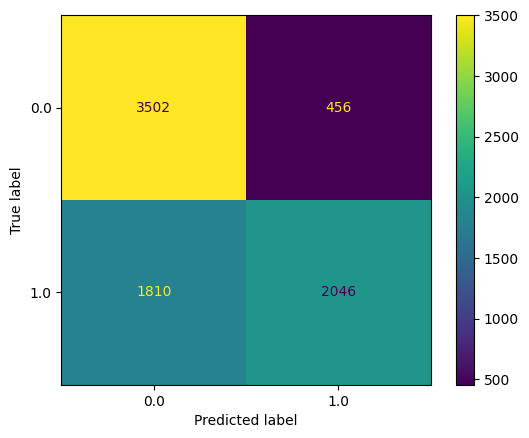

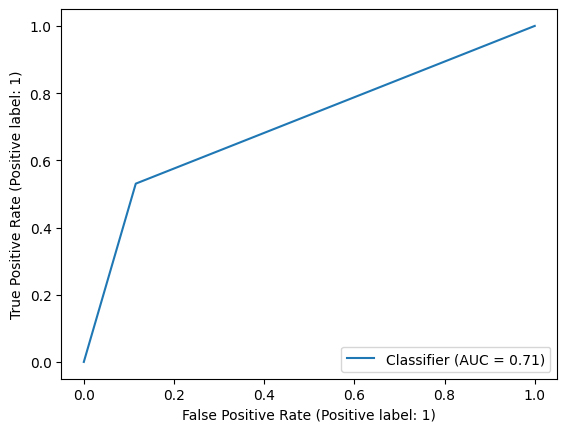

In [7]:
logReg = gcv.best_estimator_
showMetrics (logReg, testData, testLabels)

Загрузка подобранных параметров в файл .pkl

In [8]:
import pickle
with open ('logReg.pkl', 'wb') as f:
    pickle.dump (logReg, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'log__alpha': 0.0001, 'log__eta0': 0.01, 'log__max_iter': 5000} 
 0.8518956966885298
Accuracy:  0.829152802661889
Precision:  0.8584020471993176
Recall:  0.7829356846473029


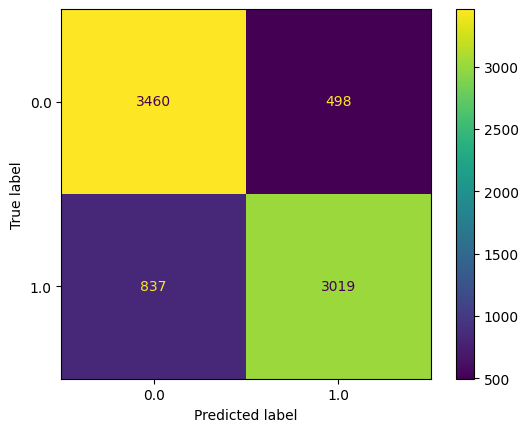

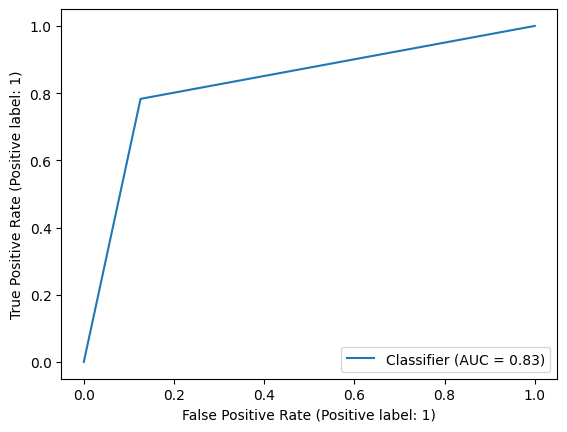

In [27]:
from sklearn.linear_model import SGDClassifier
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer()), ('log', SGDClassifier (loss = 'log_loss', learning_rate = 'constant'))]),
                    {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 5000], 
                     'log__alpha': [0.01, 0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
logRegSK = gcv.best_estimator_
showMetrics (logRegSK, testData, testLabels)

### Метод опорных векторов

Определение модели

In [10]:
class SVM (BaseEstimator, ClassifierMixin):
    def __init__ (self, lr = 0.0001, batch_size = 1000, epochs = 10, alpha = 0.0001):
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.alpha = alpha

    def fit (self, data, labels):
        self.w = np.random.normal (0, 1, (data.shape [1] + 1,))
        data = np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1)
        labels = labels * 2 - 1
        for j in range (self.epochs):
            for i in range (self.batch_size, len(data), self.batch_size):
                batchData = data [i - self.batch_size:i]
                batchLabels = labels [i - self.batch_size:i]
                grad = 2 * self.alpha * self.w
                for i, x in enumerate (batchData):
                    if (1 - x.dot (self.w) * batchLabels [i] > 0):
                        grad -= x * batchLabels [i]
                self.w -= self.lr * grad
        return self

    def predict (self, data):
        return (np.sign (np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1).dot (self.w)) + 1) / 2

Подбор гиперпараметров при помощи RandomizedSearch

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
rcv = RandomizedSearchCV (Pipeline ([('scaler', StandardScaler ()), ('svm', SVM ())]),
                    {'svm__lr': [0.01, 0.001, 0.0001], 'svm__epochs': [1, 5, 10], 
                     'svm__batch_size': [100, 1000, 10000], 'svm__alpha': [0.01, 0.001, 0.0001]})
rcv.fit (trainData, trainLabels)
print (rcv.best_params_, '\n', rcv.best_score_)

{'svm__lr': 0.001, 'svm__epochs': 1, 'svm__batch_size': 1000, 'svm__alpha': 0.001} 
 0.9502159654455287


Подбор гиперпараметров при помощи GridSearch

In [13]:
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('svm', SVM ())]),
                    {'svm__lr': [0.01, 0.001], 'svm__epochs': [1, 5, 10], 
                     'svm__batch_size': [100, 1000, 10000], 'svm__alpha': [0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'svm__alpha': 0.0001, 'svm__batch_size': 1000, 'svm__epochs': 1, 'svm__lr': 0.001} 
 0.9508558630619101


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.9513693370872792
Precision:  0.9306243805748265
Recall:  0.9740663900414938


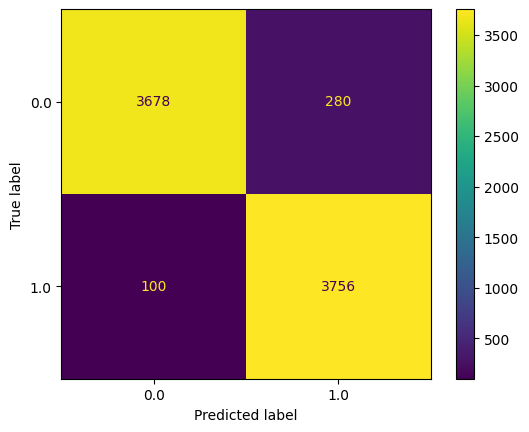

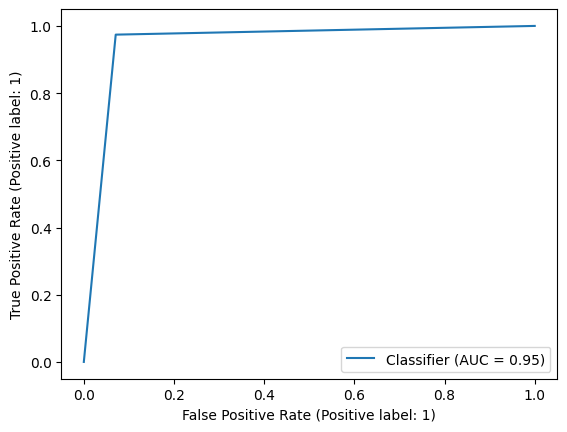

In [14]:
svm = gcv.best_estimator_
showMetrics (svm, testData, testLabels)

Загрузка подобранных параметров в файл .pkl

In [15]:
with open ('svm.pkl', 'wb') as f:
    pickle.dump (svm, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'svm__alpha': 0.0001, 'svm__eta0': 0.01, 'svm__max_iter': 5000} 
 0.836186210206367
Accuracy:  0.8518044535449194
Precision:  0.8041027953110911
Recall:  0.9250518672199171


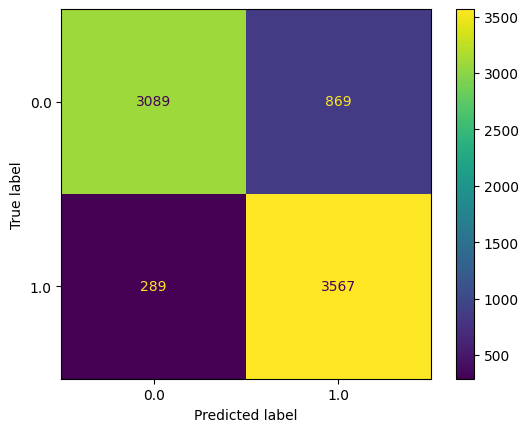

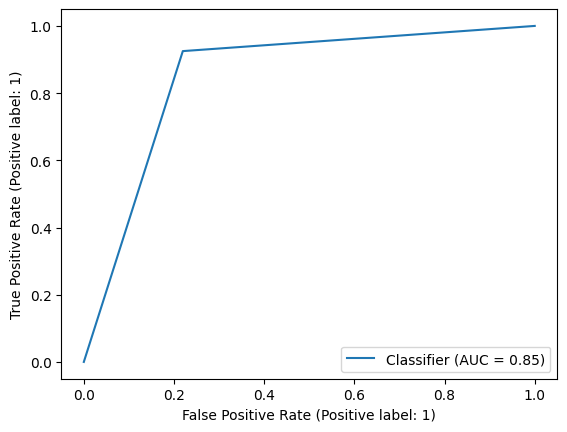

In [16]:
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer ()), ('svm', SGDClassifier (loss = 'hinge', learning_rate = 'constant'))]),
                    {'svm__eta0': [0.1, 0.01, 0.001], 'svm__max_iter': [100, 1000, 5000], 
                     'svm__alpha': [0.01, 0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
svmSK = gcv.best_estimator_
showMetrics (svmSK, testData, testLabels)

### Метод k-ближайших соседей

Определение модели

In [17]:
class KNN (BaseEstimator, ClassifierMixin):
    def __init__ (self, k = 5):
        self.k = k
    
    def fit (self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict (self, data):
        res = np.ndarray ((data.shape [0],))
        for i, x in enumerate (data):
            neighbors = np.argpartition (((self.data - data[i]) ** 2).sum (axis = 1), self.k - 1) [:self.k]
            values, counts = np.unique (self.labels [neighbors], return_counts = True)
            res[i] = values [counts.argmax ()]
        return res

Подбор гиперпараметров при помощи GridSearch

In [19]:
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('knn', KNN ())]),
                    {'knn__k': [1, 5, 11]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'knn__k': 1} 
 0.9938569828827386


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.9948809828512926
Precision:  0.9920061887570912
Recall:  0.9976659751037344


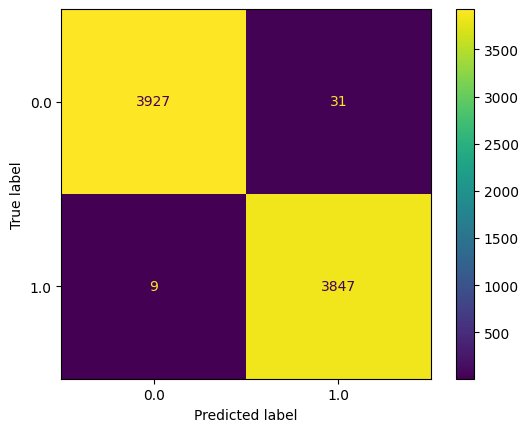

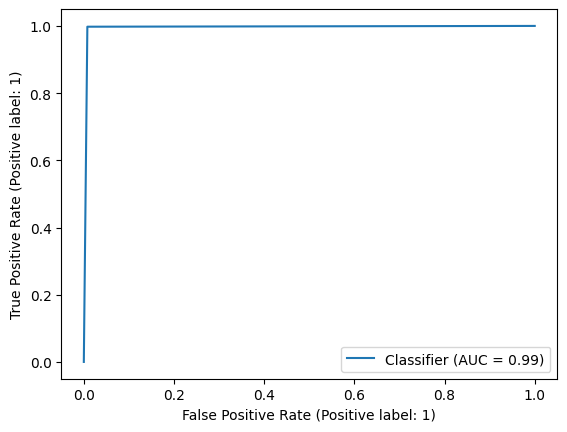

In [20]:
knn = gcv.best_estimator_
showMetrics (knn, testData, testLabels)

Загрузка подобранных параметров в файл .pkl

In [21]:
with open ('knn.pkl', 'wb') as f:
    pickle.dump (knn, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'knn__n_neighbors': 1} 
 0.9938569828827386
Accuracy:  0.9948809828512926
Precision:  0.9920061887570912
Recall:  0.9976659751037344


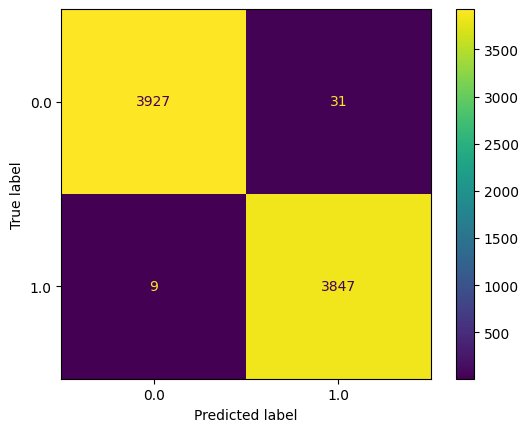

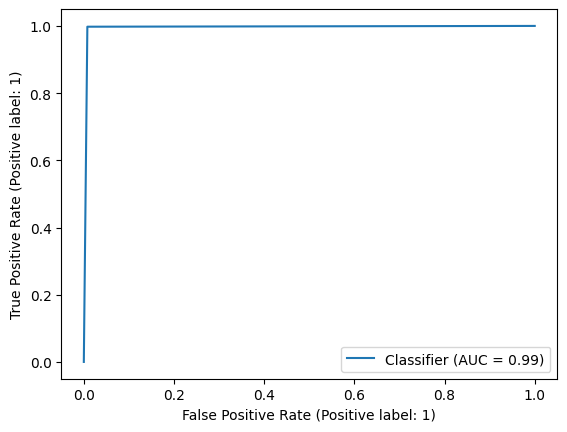

In [22]:
from sklearn.neighbors import KNeighborsClassifier
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('knn', KNeighborsClassifier ())]),
                    {'knn__n_neighbors': [1, 5, 11]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
knnSK = gcv.best_estimator_
showMetrics (knnSK, testData, testLabels)

### Наивный байесовский классификатор

Определение модели

In [23]:
from scipy.stats import gaussian_kde
class NaiveBayes (BaseEstimator, ClassifierMixin):
    def __init__ (self):
        pass
    
    def fit (self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip (*np.unique (labels, return_counts = True)):
            self.kde.append ([])
            for i in range (data.shape [1]):
                self.kde [-1].append (gaussian_kde (data [labels == c, i]))
        self.classes = np.unique (labels, return_counts = True) [1] / len (labels)
        return self
    
    def predict (self, data):
        res = np.ndarray ((data.shape [0],))
        for i, obj in enumerate (data):
            prob = np.array (self.classes)
            for j in range (len (self.classes)):
                for k, kde in enumerate (self.kde [j]):
                    prob [j] *= kde (obj [k]) [0]
            res [i] = prob.argmax ()
        return res

Вывод метрик

Accuracy:  0.7139749168159714
Precision:  0.6330651781316696
Recall:  1.0


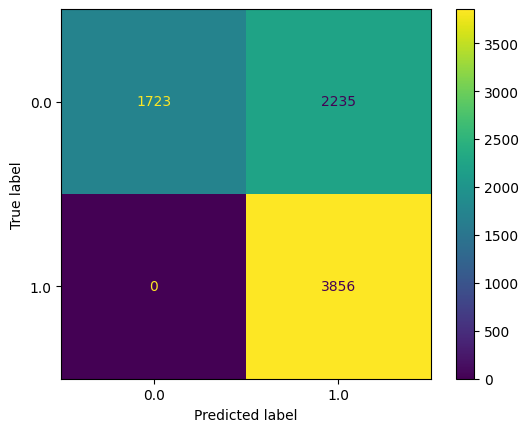

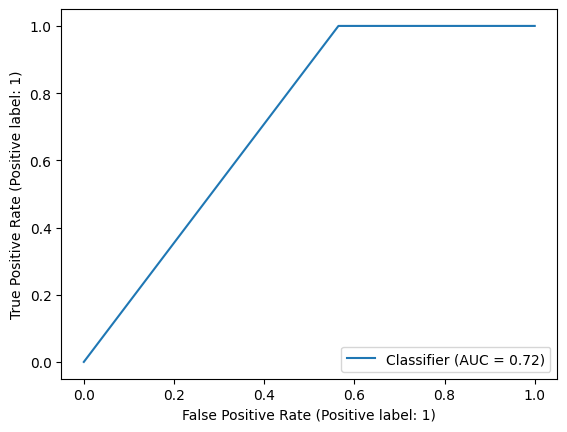

In [24]:
nb = Pipeline ([('bayes', NaiveBayes ())])
nb.fit (trainData, trainLabels)
showMetrics (nb, testData, testLabels)

Загрузка параметров в файл .pkl

In [25]:
with open ('naiveBayes.pkl', 'wb') as f:
    pickle.dump (nb, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

Accuracy:  0.8832864090094702
Precision:  0.8246581385090428
Recall:  0.9696576763485477


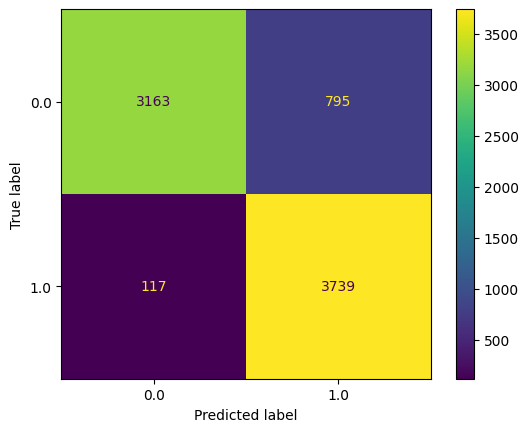

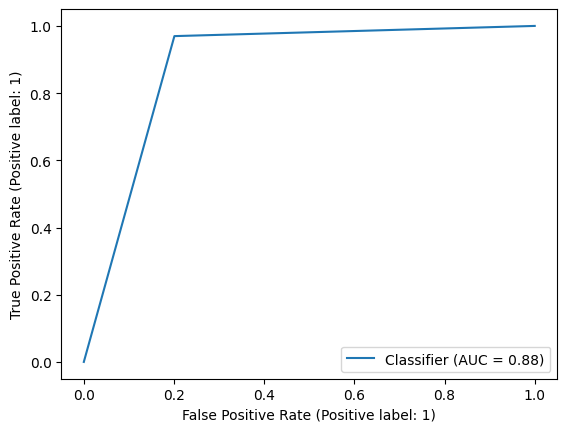

In [26]:
from sklearn.naive_bayes import GaussianNB
gnbSK = GaussianNB ()
gnbSK.fit (trainData, trainLabels)
showMetrics (gnbSK, testData, testLabels)